In [1]:
# Imports and Defines

# imports
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import ast

from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
previousStepsToShow = 15;

# Define Univariate Time-Series to study
stepsToForecast = [1, 3, 12]

# Read CSV file and parse dates
df = pd.read_csv('Consumer_all_items_normal.csv', parse_dates=['date'], index_col=['date'])

# Subset the data by date range
df = df.loc['1996-11-01':'2023-02-01']


# Split the data into train and test sets
df_train = df[['value']][:-stepsToForecast[-1]].rename(columns={'value': 'train'})
df_test = df[['value']][-stepsToForecast[-1]:].rename(columns={'value': 'test'})


title = 'CPI: Historical inflation rate'
serie = "CPI"
xlab = 'Months/Year'; 
ylab = 'Historical inflation rate';
seasonal_periods=12;

model_type = 'multiplicative'

In [5]:
df.head()

,value
date,
1996-11-01,67.8
1996-12-01,67.8
1997-01-01,67.5
1997-02-01,67.9
1997-03-01,68.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 1996-11-01 to 2023-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   316 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [7]:
# Summary statistics
print(df.describe(percentiles=[.1, .25, .5, .75, .9]))
print("var    %.6f" % np.var(df))

            value
count  316.000000
mean    92.795253
std     11.993258
min     67.500000
10%     71.100000
25%     85.400000
50%     98.300000
75%    100.900000
90%    102.350000
max    116.700000
var    143.383047


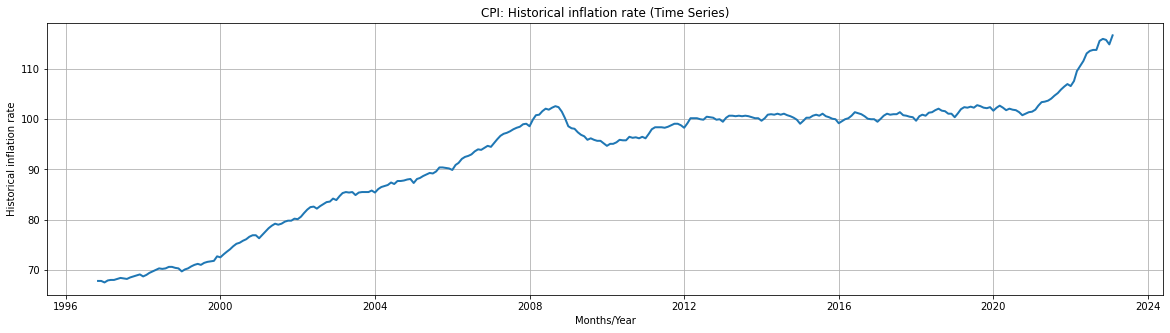

In [8]:
# Data Visualization

# Let's visualize the data to have an idea of what we are looking at
plt.figure(figsize=(20,5))
plt.plot(df.index, df.values, linewidth=2)
plt.title(title + ' (Time Series)')
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid(True)

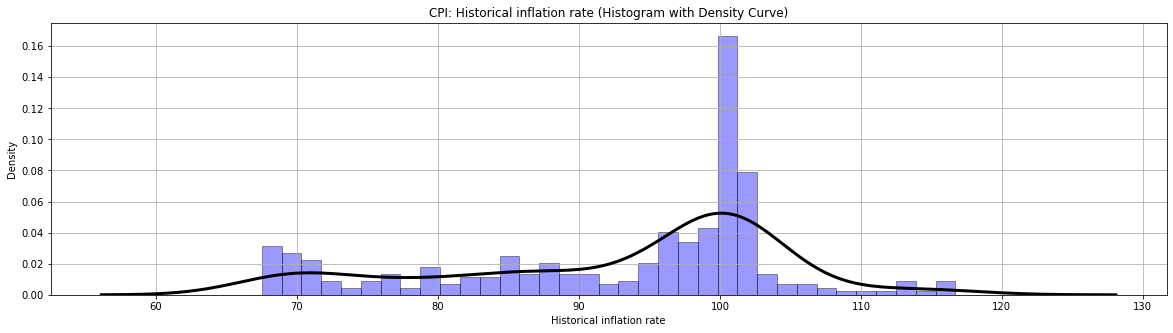

In [9]:
# Histogram plot with depicted density and rug
plt.figure(figsize=(20,5))
sns.distplot(df, 
             bins = 35, color='blue',
             hist = True, hist_kws={'edgecolor':'black'},
             kde = True, kde_kws={"color": "black", "lw": 3, "label": "KDE"},
             # rug = True, rug_kws={'edgecolor':'orange'}
            )
plt.title(title + ' (Histogram with Density Curve)')
plt.ylabel('Density')
plt.xlabel(ylab)
plt.grid(True)

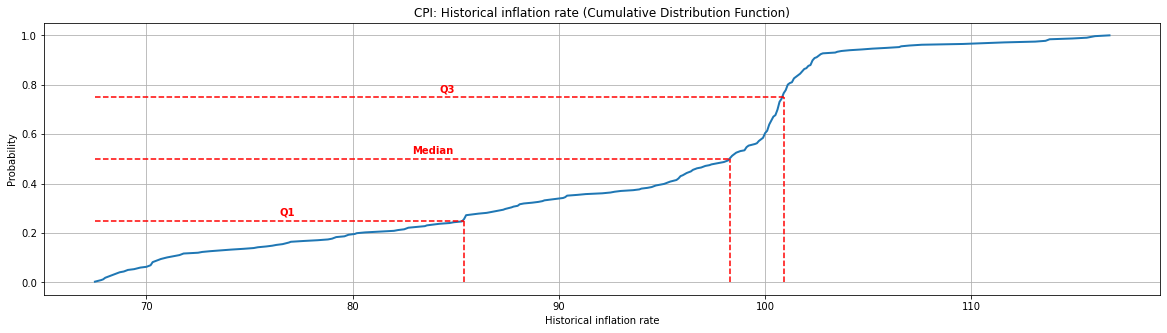

In [10]:
# Cumulative Distribution Function
cdf = df[df.columns.values[0]].value_counts().sort_index().div(len(df)).cumsum()
cdf.plot(figsize=(20,5), linewidth=2)
plt.title(title + ' (Cumulative Distribution Function)')
plt.ylabel('Probability')
plt.xlabel(ylab)
minVal = df.values.min()
q25 = np.quantile(df.values, .25)
medianVal = np.quantile(df.values, .5)
q75 = np.quantile(df.values, .75)
data=[(minVal, q25), (.25, .25), 'r', (q25, q25), (0, .25), 'r', \
      (minVal, medianVal), (.5, .5), 'r', (medianVal, medianVal), (0, .5), 'r', \
      (minVal, q75), (.75, .75), 'r', (q75, q75), (0, .75), 'r']
plt.plot(*data, ls='--');
plt.text(minVal+(q25-minVal)/2, 0.27, "Q1", color='r', fontweight='bold')
plt.text(minVal+(medianVal-minVal)/2, 0.52, "Median", color='r', fontweight='bold')
plt.text(minVal+(q75-minVal)/2, 0.77, "Q3", color='r',  fontweight='bold')
plt.grid(True)

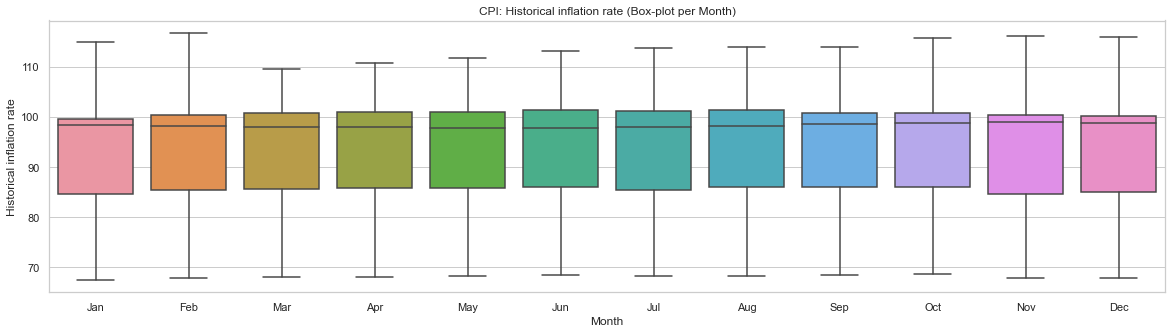

In [11]:
# Box and Whisker plot monthly
sns.set(rc={'figure.figsize':(20,5)})
sns.set(style="whitegrid")
box_plot = sns.boxplot(x=df.index.month, y=df.columns.values[0], data=df);
box_plot.set(xlabel='Month', ylabel=ylab, title= title + ' (Box-plot per Month)');
box_plot.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

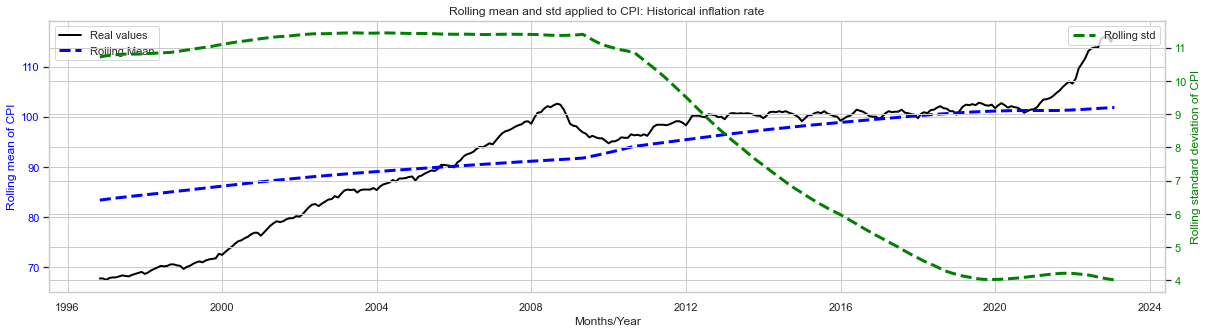

In [12]:
# Data Analysis

# Let's visually assess data stationarity through rolling mean and std
rolling_window = 300
rolling_mean = df.rolling(rolling_window, center=True, min_periods=1).mean() 
rolling_std  = df.rolling(rolling_window, center=True, min_periods=1).std() 

fig, axMean = plt.subplots(figsize=(20,5))

axMean.plot(df.index, df.values, label = title, linewidth=2, color='black')
axMean.plot(rolling_mean, linestyle='--', linewidth=3, color='blue')
axMean.set_xlabel(xlab)
axMean.set_ylabel('Rolling mean of ' + serie, color='blue')
axMean.legend(['Real values','Rolling Mean'])
axMean.tick_params(axis='y', labelcolor='blue')

axStd = axMean.twinx()
axStd.plot(rolling_std, label='Rolling std', linestyle='--', color='green', linewidth=3)
axStd.set_ylabel(ylab)
axStd.legend(['Rolling std'])
axStd.set_ylabel('Rolling standard deviation of ' + serie, color='green')
axStd.tick_params(axis='y', labelcolor='green')

axMean.set_title('Rolling mean and std applied to ' + title)
plt.show()

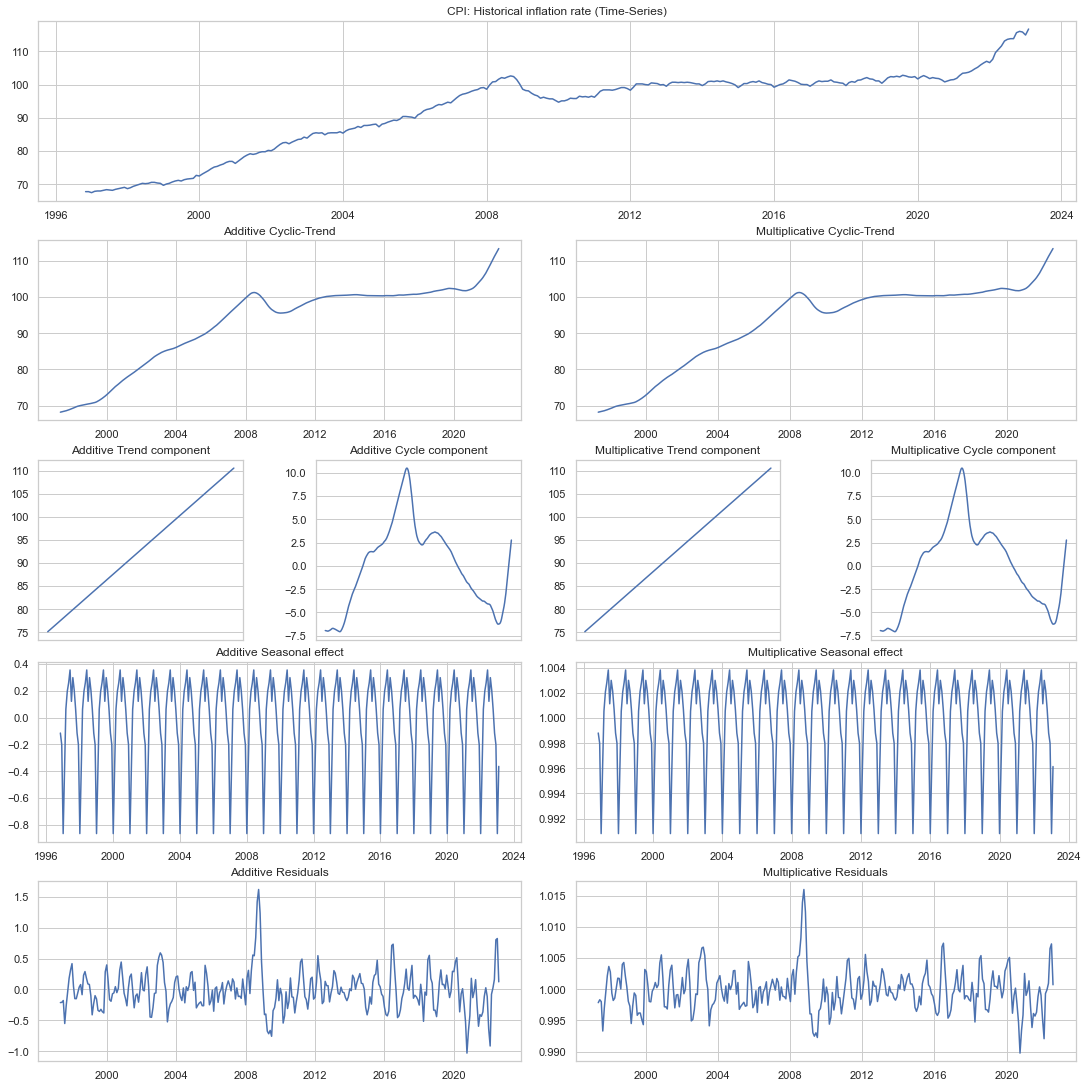

In [13]:
# As it should be known, a time series can typically be decomposed as:
#Additive Time Series = Level + CyclicTrend + Residual + Seasonality 
#Multiplicative Time Series = Level*CyclicTrend*Residual*Seasonality 

# Therefore, we will decompose the time series assuming it is both an additive and multiplicative model
#and we will infer in its type based on the residual fit given at the end

# Seasonal decomposition using moving averages
resultAdd = seasonal_decompose(df, model='additive',       period=seasonal_periods)
resultMul = seasonal_decompose(df, model='multiplicative', period=seasonal_periods)
# Hodrick-Prescott filter
# See Ravn and Uhlig: http://home.uchicago.edu/~huhlig/papers/uhlig.ravn.res.2002.pdf
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend[resultAdd.trend.notna().values], lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend[resultMul.trend.notna().values], lamb=lamb)

fig = plt.figure(figsize=(15,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

fig.add_subplot(spec[0, :])
plt.plot(df)

plt.title(title + ' (Time-Series)')
# Additive model
fig.add_subplot(spec[1, :2])
plt.plot(resultAdd.trend)
plt.title('Additive Cyclic-Trend')
fig.add_subplot(spec[2, 0])
plt.plot(trendAdd)
plt.xticks([])
plt.title('Additive Trend component')
fig.add_subplot(spec[2, 1])
plt.plot(cycleAdd)
plt.xticks([])
plt.title('Additive Cycle component')
fig.add_subplot(spec[3, :2])
plt.plot(resultAdd.seasonal)
plt.title('Additive Seasonal effect')
fig.add_subplot(spec[4, :2])
plt.plot(resultAdd.resid)
plt.title('Additive Residuals')

# Multiplicative model
fig.add_subplot(spec[1, 2:])
plt.plot(resultMul.trend)
plt.title('Multiplicative Cyclic-Trend')
fig.add_subplot(spec[2, 2])
plt.plot(trendMul)
plt.xticks([])
plt.title('Multiplicative Trend component')
fig.add_subplot(spec[2, 3])
plt.plot(cycleMul)
plt.xticks([])
plt.title('Multiplicative Cycle component')
fig.add_subplot(spec[3, 2:])
plt.plot(resultMul.seasonal)
plt.title('Multiplicative Seasonal effect')
fig.add_subplot(spec[4, 2:])
plt.plot(resultMul.resid)
plt.title('Multiplicative Residuals')
plt.show()

In [14]:
print("Time-Series Level is " + str(round(df.mean(), 2)))
print("")
print("Additive Time Series")
FtAdd = max(0, 1-np.var(resultAdd.resid)/np.var(resultAdd.trend));
print("Strenght of Trend: %.4f" % FtAdd )
FsAdd = max(0, 1-np.var(resultAdd.resid)/np.var(resultAdd.seasonal));
print("Strenght of Seasonality: %.4f" % FsAdd )
print("")
print("Multiplicative Time Series")
FtMul = max(0, 1-np.var(resultMul.resid)/np.var(resultMul.trend));
print("Strenght of Trend: %.4f" % FtMul )
FsMul = max(0, 1-np.var(resultMul.resid)/np.var(resultMul.seasonal));
print("Strenght of Seasonality: %.4f" % FsMul )

Time-Series Level is value    92.8
dtype: float64

Additive Time Series
Strenght of Trend: 0.9992
Strenght of Seasonality: 0.0627

Multiplicative Time Series
Strenght of Trend: 1.0000
Strenght of Seasonality: 0.1293


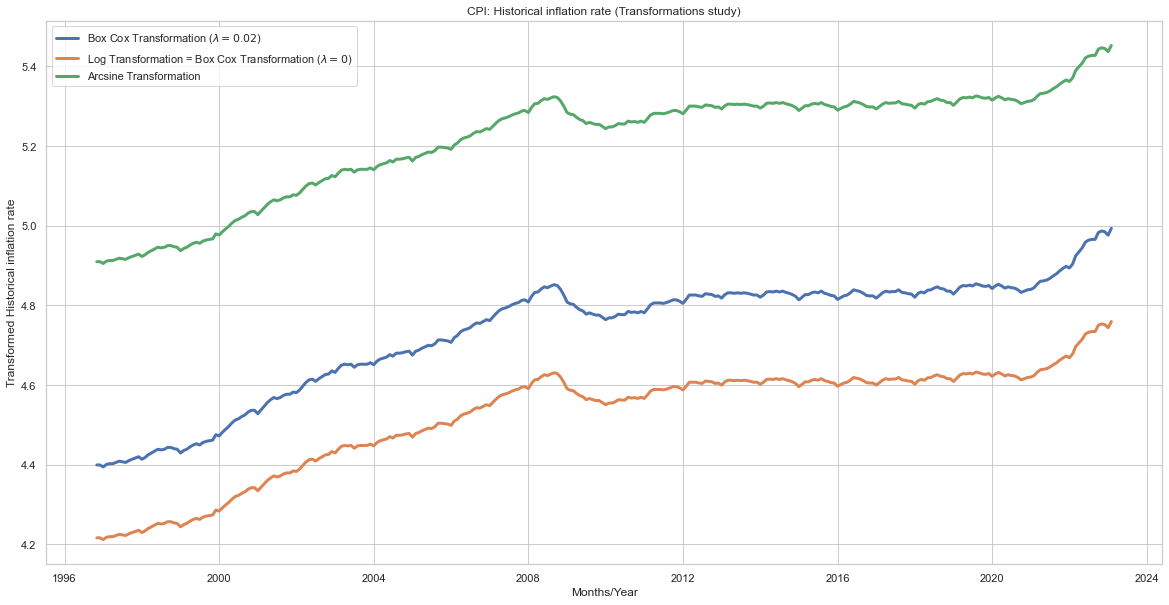

In [15]:
# Data Normalization
fig = plt.figure(figsize=(20,10))
# The Box-Cox transformation intends to transform data to be closer to normality, 
#or tranform heteroskedastic (non constant variance) data to be closer to homoskedasticity (constant variance).
plt.plot(df.index, stats.boxcox(df[df.columns[0]].values, lmbda=.02), label = 'Box Cox Transformation '+u'($\lambda=0.02$)', lw=3)
# The log transform (particular Box-Cox case) can be used where the data has a positively skewed distribution,
#and there are a few very large values. If the latter is in the area of study,
#the transform is likely to make variance more constant and normalize data
plt.plot(df.index, stats.boxcox(df[df.columns[0]].values, lmbda=0), label = 'Log Transformation = Box Cox Transformation '+u'($\lambda=0$)', lw=3)
# The arcsine transformation will help make the variances more constant throughout 
#your study area and often makes the data appear normally distributed as well.
plt.plot(df.index, np.arcsinh(df[df.columns[0]].values), label = 'Arcsine Transformation', lw=3)

plt.legend(loc='best')
plt.title(title + ' (Transformations study)')
plt.xlabel(xlab)
plt.ylabel('Transformed ' + ylab);

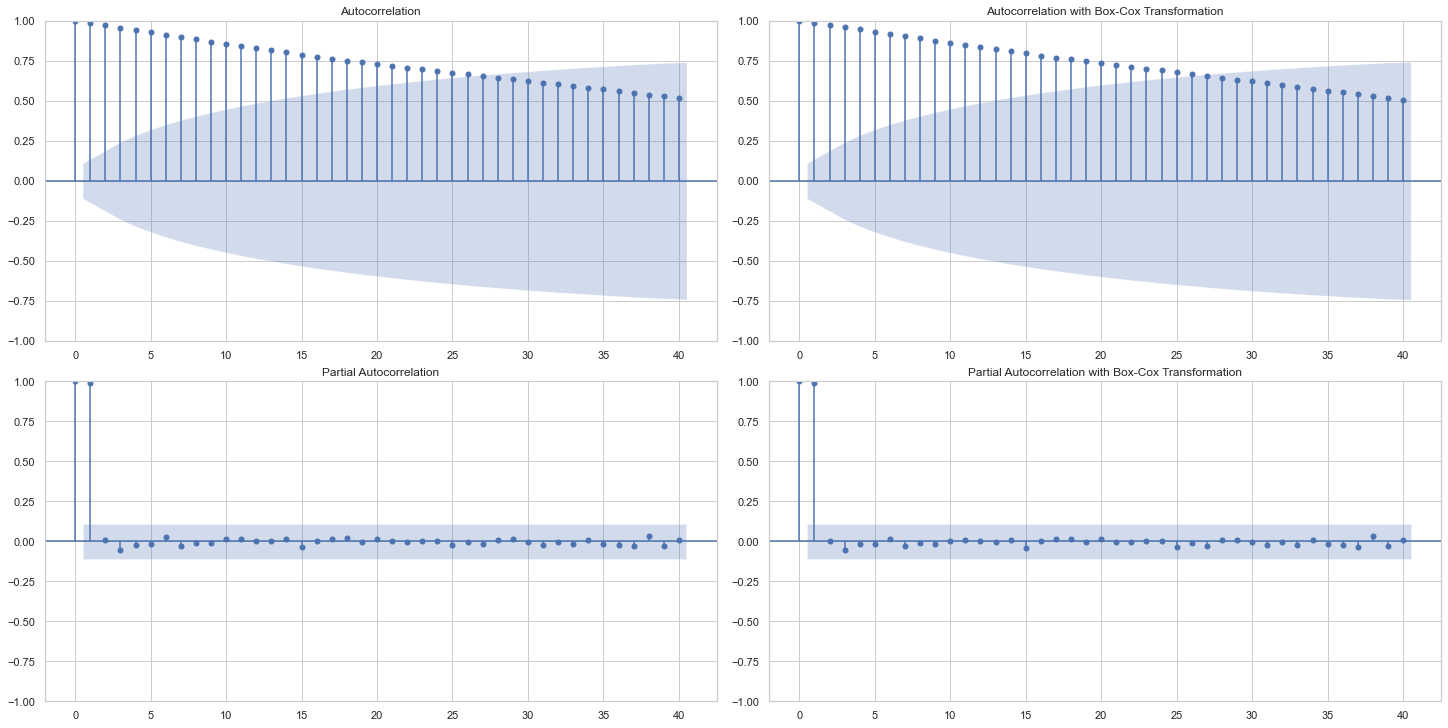

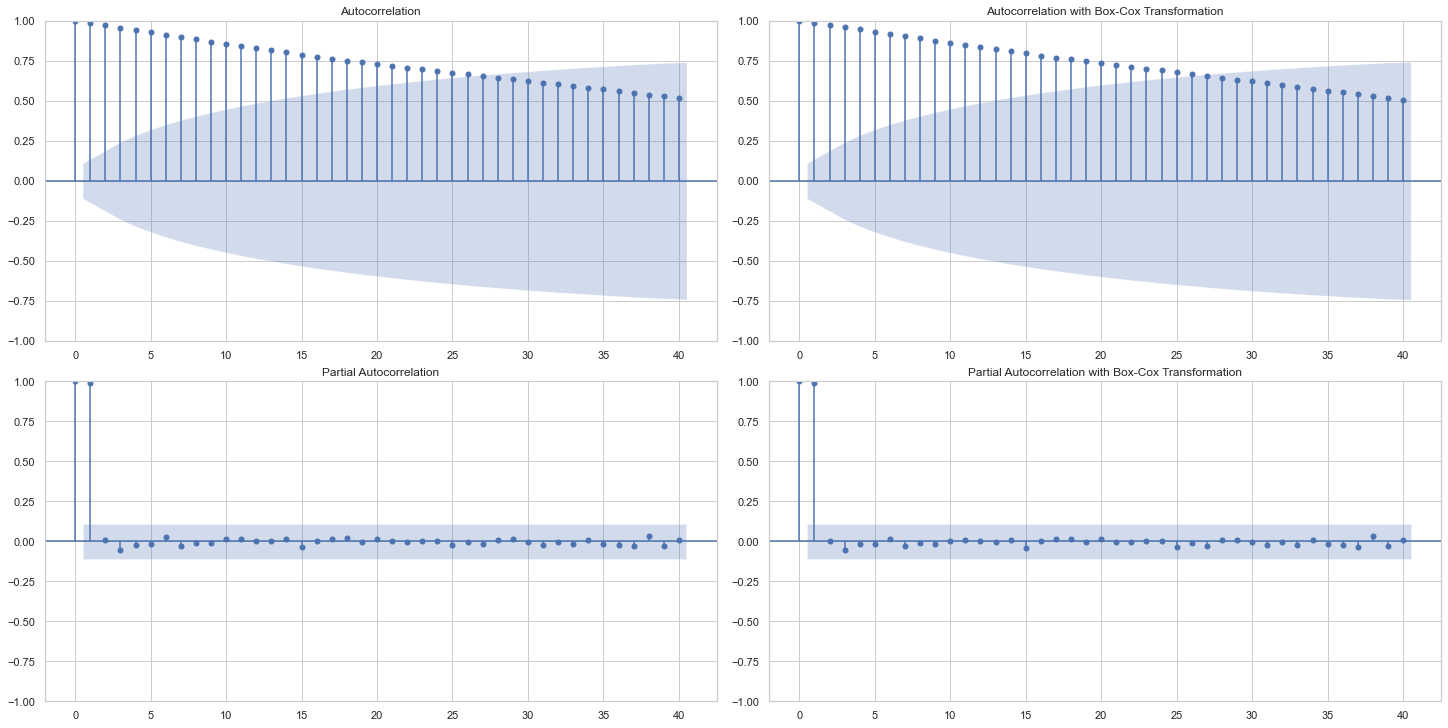

In [16]:
# Correlation plots
maxLags = 40
# The effect of applying Box-Cox transformation against original time series
df_boxCox = stats.boxcox(df[df.columns[0]].values, lmbda=0)

fig = plt.figure(figsize=(20,10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df, lags=maxLags, ax=ax_acf)
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df, lags=maxLags, ax=ax_pacf);

# Auto-correlation function for time series transformed with Box-Cox
ax_acfBoxCox = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(df_boxCox, lags=maxLags, ax=ax_acfBoxCox, title='Autocorrelation with Box-Cox Transformation')
# Partial auto-correlation function for time series transformed with Box-Cox
ax_pacfBoxCox = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(df_boxCox, lags=maxLags, ax=ax_pacfBoxCox, title='Partial Autocorrelation with Box-Cox Transformation')

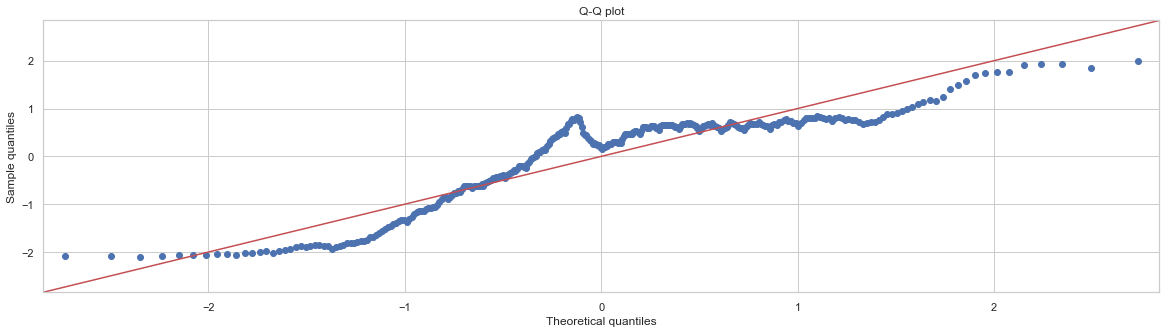

In [17]:
# Q-Q plot
# Compare time series against a standard normal curve
qqplot(df.values, stats.distributions.norm, fit=True, line='45')
plt.title('Q-Q plot');
plt.ylabel('Sample quantiles')
plt.xlabel('Theoretical quantiles')
plt.grid(True)

In [18]:
# Hypothesis Test

# Kurtosis 
# Measures height and sharpness of the central peak relative to that of a standard bell curve
k, kpval = kurtosistest(df)
kurtosis_val = kurtosis(df, fisher=True)
print("Kurtosis Test for " + serie)
print("Statistic: %.4f" % k[0])
print("p-value: %.4f" % kpval[0])
print(" ")
print("Kurtosis value: %.4f" % kurtosis_val[0])

Kurtosis Test for CPI
Statistic: -2.1836
p-value: 0.0290
 
Kurtosis value: -0.4861


In [19]:
# Skewness
# Measure of the asymmetry of the probability distribution of a random variable about its mean
s, spval = skewtest(df)
skew_val = skew(df)
print("Skew Test for " + serie)
print("Statistic: %.4f" % s[0])
print("p-value: %.4f" % spval[0]) 
print(" ")
print("Skewness value: %.4f" % skew_val[0]) 

Skew Test for CPI
Statistic: -4.8358
p-value: 0.0000
 
Skewness value: -0.7182


In [20]:
# Jarque-Bera goodness of fit test on sample data
# Tests if the sample data has the skewness and kurtosis matching a normal distribution
jb, jbpval= stats.jarque_bera(df)
print("Jarque-Bera Test for " + serie)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval) 

Jarque-Bera Test for CPI
Statistic: 30.2764
p-value: 0.0000


In [21]:
# Kolmogorov-Smirnov Test goodness of fit test on sample data
ks, kspval = stats.kstest(df.values, 'norm')
print("Kolmogorov-Smirnov Test for " + serie)
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)  

Kolmogorov-Smirnov Test for CPI
Statistic: 1.0000
p-value: 0.0000


In [22]:
# Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH)
lm, lmpval, fval, fpval = het_arch(df[df.columns.values[0]].values)
print("Lagrange Mltiplier Test for " + serie)
print("Statistic: %.4f" % lm)
print("p-value: %.4f" % lmpval)
print(" ")
print("fstatistic for F test")
print("Statistic: %.4f" % fval)
print("p-value: %.4f" % fpval)

Lagrange Mltiplier Test for CPI
Statistic: 305.4698
p-value: 0.0000
 
fstatistic for F test
Statistic: 16996.8221
p-value: 0.0000


In [23]:
# The Augmented Dickey-Fuller test 
# Used to test for a unit root in a univariate process in the presence of serial correlation.
#regression{‘c’,’ct’,’ctt’,’nc’} 'c' - Constant and 't'-trend order to include in regression 
    #Note: 'ct' - The data is stationary around a trend
result = adfuller(df[df.columns.values[0]].values, regression='c')
print("Augmented Dickey-Fuller Test for " + serie)
print("ADF Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey-Fuller Test for CPI
ADF Statistic: -0.7909
p-value: 0.8218
Used lags: 16
Num obs: 299
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [24]:
# Kwiatkowski-Phillips-Schmidt-Shin test
# Test for level or trend stationarity
# Note: regressionstr{‘c’, ‘ct’}
#regressionstr{‘c’, ‘ct’} wher: 
    # ‘c’  : The data is stationary around a constant (default).
    # ‘ct’ : The data is stationary around a trend.
#lags{None, ‘auto’, ‘legacy’}
    # see: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
result = kpss(df[df.columns.values[0]].values, regression='c')
print("Kwiatkowski-Phillips-Schmidt-Shin Test for " + serie)
print("KPSS Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

Kwiatkowski-Phillips-Schmidt-Shin Test for CPI
KPSS Statistic: 2.3753
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347
